In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [3]:
import pandas as pd
import seaborn as sns
sns.set()
import os
from tqdm import tqdm_notebook
from scipy.cluster import hierarchy

In [45]:
X = pd.read_table('/BioII/lulab_b/caojingyi/exoRBase/05.matrix/exosome.sequentialMap.featureCounts.merged.mx')
X.columns = X.columns.str.strip('lulab_')
print(X.shape)
X.head()

(854770, 45)


,SRR5712486,SRR5712487,SRR5712488,SRR5712489,SRR5712490,SRR5712491,SRR5712492,SRR5712493,SRR5712494,SRR5712495,...,SRR5712527,SRR5712528,SRR5712529,SRR5712530,SRR5712531,SRR5712532,SRR5712533,SRR5712534,SRR5712535,SRR5712536
miRNA_ENSG00000278267.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miRNA_ENSG00000284332.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miRNA_ENSG00000273874.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miRNA_ENSG00000278791.1,6710,27035,4313,3476,21049,21990,12621,6089,7589,13835,...,1105,3656,3402,3289,1476,9261,5420,10256,6511,7824
miRNA_ENSG00000207730.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
sample_info = pd.read_table('/BioII/lulab_b/caojingyi/exoRBase/list_info', 
                            names=['sample_id', 'label'], sep=r'\s+', index_col=0)
print(sample_info.shape)
labels = sample_info.loc[:, 'label']
sample_info.head()

(45, 1)


,label
sample_id,
SRR5712520,HCC
SRR5712521,HCC
SRR5712522,HCC
SRR5712523,HCC
SRR5712524,HCC


In [20]:
np.unique(labels, return_counts=True)

(array(['HCC', 'Normal'], dtype=object), array([17, 28]))

## Select Normal samples

In [46]:
X = X.loc[:, labels[labels == 'Normal'].index.values]

In [51]:
## Remove genes with zero counts
gene_counts = np.exp(np.mean(np.log(X + 1), axis=1)) - 1
X_counts = X.iloc[gene_counts.values > 5].copy()
print(X_counts.shape)

(5723, 28)


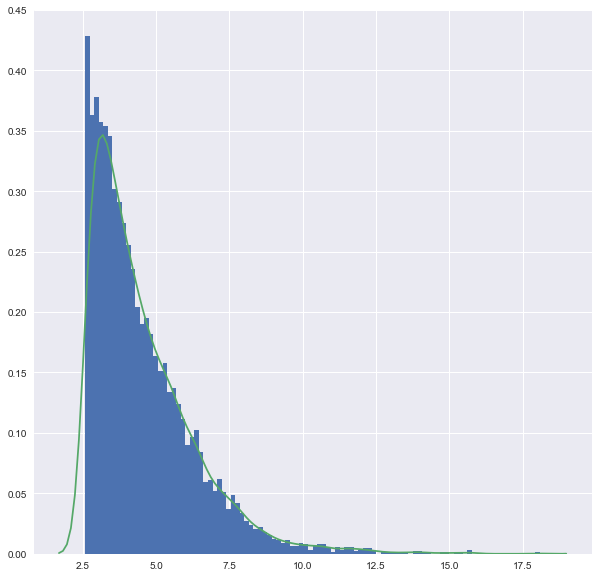

In [52]:
gene_counts = np.exp(np.mean(np.log(X_counts + 1), axis=1)) - 1
log_gene_counts = np.log2(gene_counts + 1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(log_gene_counts, bins=100, normed=True)
sns.kdeplot(log_gene_counts, ax=ax)

In [53]:
log_seq_depth = np.log2(X_counts.sum(axis=0) + 1)

HBox(children=(IntProgress(value=0, max=5723), HTML(value='')))

Text(0,0.5,'Pearson correlation R')

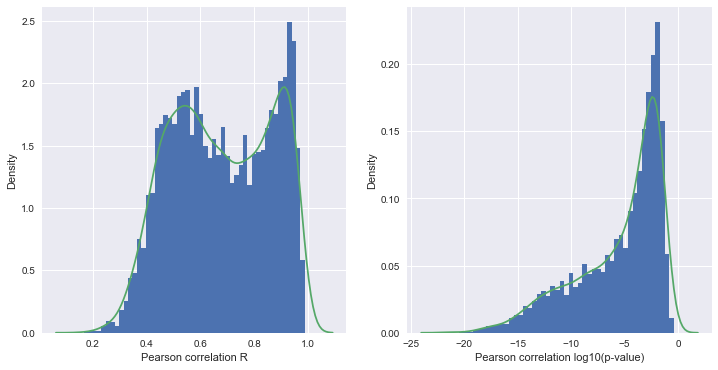

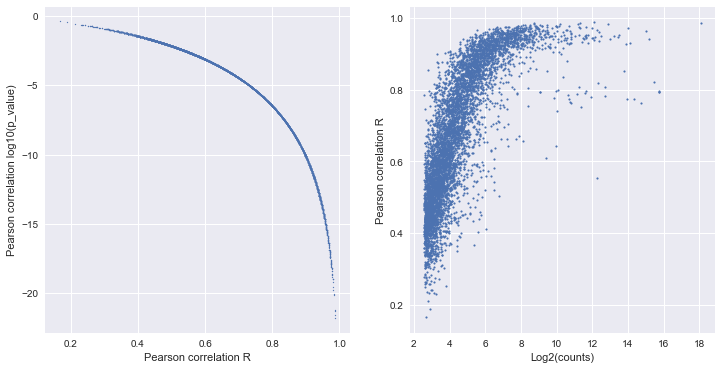

In [57]:
from scipy.stats import linregress, pearsonr
pearson_rs = np.zeros(X_counts.shape[0]) 
pearson_ps = np.zeros(X_counts.shape[0])
for i in tqdm_notebook(range(X_counts.shape[0])):
    pearson_rs[i], pearson_ps[i] = pearsonr(log_seq_depth, np.log2(X_counts.values[i, :] + 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(pearson_rs, bins=50, normed=True)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Density')
sns.kdeplot(pearson_rs, ax=axes[0])

axes[1].hist(np.log10(pearson_ps), bins=50, normed=True)
axes[1].set_xlabel('Pearson correlation log10(p-value)')
axes[1].set_ylabel('Density')
sns.kdeplot(np.log10(pearson_ps), ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(pearson_rs, np.log10(pearson_ps), s=1)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Pearson correlation log10(p_value)')
axes[1].scatter(log_gene_counts, pearson_rs, s=3)
axes[1].set_xlabel('Log2(counts)')
axes[1].set_ylabel('Pearson correlation R')

In [67]:
X_cpm = 1e6*X_counts.astype('float').div(X_counts.sum(axis=0), axis=1)
X_cpm.head()

,SRR5712486,SRR5712487,SRR5712488,SRR5712489,SRR5712490,SRR5712491,SRR5712492,SRR5712493,SRR5712494,SRR5712495,...,SRR5712504,SRR5712505,SRR5712506,SRR5712507,SRR5712508,SRR5712509,SRR5712510,SRR5712511,SRR5712512,SRR5712513
miRNA_ENSG00000278791.1,4781.255767,12441.938006,2083.623195,1508.577758,7749.877303,14469.989741,7351.720498,3687.161122,4369.613195,6690.126032,...,3175.352873,9744.798464,1086.103904,957.032120,9255.620372,765.925181,2157.653172,9515.500177,879.451776,5395.112663
miRNA_ENSG00000264881.1,21.376702,85.139949,38.648239,129.331465,12.886394,132.921234,28.542453,12.716437,33.395383,10.154871,...,60.084521,34.605918,0.000000,33.505883,75.379845,34.724219,23.596806,27.265043,6.855415,19.834973
miRNA_ENSG00000266802.1,13.538578,24.391445,12.077575,29.077880,4.786375,38.165503,13.979977,16.955249,8.060955,17.891916,...,15.211271,15.591678,0.000000,25.373387,17.564236,10.246491,6.788122,27.265043,8.814105,0.000000
miRNA_ENSG00000264834.1,54.154313,119.195929,81.161302,117.613513,34.977355,164.506477,24.464960,36.332677,64.487637,54.159314,...,23.197189,90.507787,60.339106,69.288865,103.921728,42.693711,45.254149,27.265043,20.239796,99.174865
miRNA_ENSG00000266188.1,90.494707,210.318686,211.116007,249.114969,78.422912,349.411758,130.479787,172.580213,98.458803,144.586027,...,164.662011,141.846237,0.000000,100.192350,191.742906,36.147342,61.739589,245.385391,106.095704,99.174865


In [69]:
X_counts.head()

,SRR5712486,SRR5712487,SRR5712488,SRR5712489,SRR5712490,SRR5712491,SRR5712492,SRR5712493,SRR5712494,SRR5712495,...,SRR5712504,SRR5712505,SRR5712506,SRR5712507,SRR5712508,SRR5712509,SRR5712510,SRR5712511,SRR5712512,SRR5712513
miRNA_ENSG00000278791.1,6710,27035,4313,3476,21049,21990,12621,6089,7589,13835,...,8350,25625,36,2942,25294,2691,6675,349,2694,272
miRNA_ENSG00000264881.1,30,185,80,298,35,202,49,21,58,21,...,158,91,0,103,206,122,73,1,21,1
miRNA_ENSG00000266802.1,19,53,25,67,13,58,24,28,14,37,...,40,41,0,78,48,36,21,1,27,0
miRNA_ENSG00000264834.1,76,259,168,271,95,250,42,60,112,112,...,61,238,2,213,284,150,140,1,62,5
miRNA_ENSG00000266188.1,127,457,437,574,213,531,224,285,171,299,...,433,373,0,308,524,127,191,9,325,5


HBox(children=(IntProgress(value=0, max=5723), HTML(value='')))

Text(0,0.5,'Pearson correlation R')

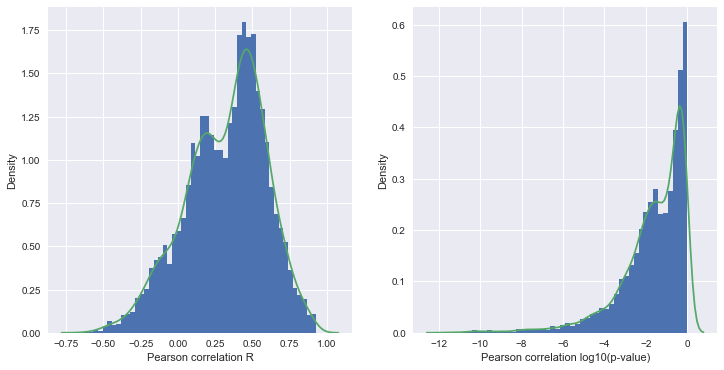

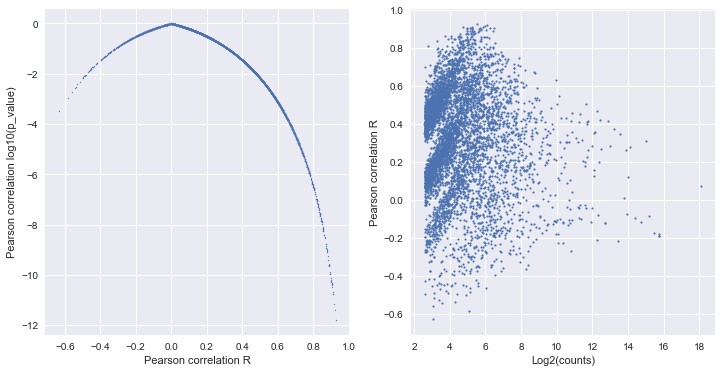

In [68]:
pearson_rs = np.zeros(X_cpm.shape[0]) 
pearson_ps = np.zeros(X_cpm.shape[0])
for i in tqdm_notebook(range(X_cpm.shape[0])):
    pearson_rs[i], pearson_ps[i] = pearsonr(log_seq_depth, np.log2(X_cpm.values[i, :] + 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(pearson_rs, bins=50, normed=True)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Density')
sns.kdeplot(pearson_rs, ax=axes[0])

axes[1].hist(np.log10(pearson_ps), bins=50, normed=True)
axes[1].set_xlabel('Pearson correlation log10(p-value)')
axes[1].set_ylabel('Density')
sns.kdeplot(np.log10(pearson_ps), ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(pearson_rs, np.log10(pearson_ps), s=1)
axes[0].set_xlabel('Pearson correlation R')
axes[0].set_ylabel('Pearson correlation log10(p_value)')
axes[1].scatter(log_gene_counts, pearson_rs, s=3)
axes[1].set_xlabel('Log2(counts)')
axes[1].set_ylabel('Pearson correlation R')